## Libraries and imports


In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
import re
from pycocotools.coco import COCO
from matplotlib import pyplot as plt
from tempfile import TemporaryDirectory

from PIL import Image
import time
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models
from torchvision import utils, transforms
from torchvision.io import read_image, ImageReadMode
from torch import nn

import skimage.io as io

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

plt.ion()

##  Data path and Global Variables

In [ ]:
dataDir_1 = 'drive/MyDrive/Colab Notebooks/samolet/data/train/images/'
dataDir_2 = 'drive/MyDrive/Colab Notebooks/samolet/data/train/additional_images/'
dataDir_3 = 'drive/MyDrive/Colab Notebooks/samolet/data/train/generated_images/'
cellDir = 'drive/MyDrive/Colab Notebooks/samolet/data/train/cells_0/'
modelDir = 'drive/MyDrive/Colab Notebooks/samolet/data/train/model/'
TRAIN_SIZE = .75
BATCH_SIZE = 16

dataType = 'default'
annFile = '{}annotations/instances_{}.json'.format(dataDir_1,dataType)
ann_path_1 = 'drive/MyDrive/Colab Notebooks/samolet/data/train/images/annotations/instances_default.json'
ann_path_2 = 'drive/MyDrive/Colab Notebooks/samolet/data/train/additional_images/annotations/instances_default.json'
ann_path_3 = 'drive/MyDrive/Colab Notebooks/samolet/data/train/generated_images/annotations/instances_default.json'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


## Load COCO Annotations

In [ ]:
coco = COCO(annFile)
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO category names: \n{}\n'.format(' '.join(nms)))
print('COCO categories: \n{}\n', cats)
nms = set([cat['supercategory'] for cat in cats])
#print('COCO supercategories: \n{}'.format(' '.join(nms)))

loading annotations into memory...
Done (t=0.90s)
creating index...
index created!
COCO category names: 
window filled empty

COCO categories: 
{}
 [{'id': 1, 'datatorch_id': '45276db6-7511-4dfe-bb59-585eb6ea7570', 'name': 'window', 'supercategory': None}, {'id': 3, 'datatorch_id': '2329c069-ca4e-4294-8920-0fbd64dce07f', 'name': 'filled', 'supercategory': None}, {'id': 2, 'datatorch_id': '85972bdb-e3e6-494e-a852-452a42612ee4', 'name': 'empty', 'supercategory': None}]


## Creating a Data Frame

In [ ]:
df_anns = pd.DataFrame(coco.anns).T
df_anns.set_index("id", inplace=True)
df_anns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1491 entries, 1 to 1491
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   datatorch_id  1491 non-null   object
 1   image_id      1491 non-null   object
 2   category_id   1491 non-null   object
 3   segmentation  1491 non-null   object
 4   area          1491 non-null   object
 5   bbox          1491 non-null   object
 6   iscrowd       1491 non-null   object
 7   metadata      1491 non-null   object
dtypes: object(8)
memory usage: 104.8+ KB


In [ ]:
df_images = pd.DataFrame(coco.imgs).T
df_images.rename({"id" : "image_id"}, axis=1, inplace=True)
df_images.set_index("image_id", inplace=True)
df_images.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 1 to 16
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   datatorch_id   16 non-null     object
 1   storage_id     16 non-null     object
 2   path           16 non-null     object
 3   width          16 non-null     object
 4   height         16 non-null     object
 5   file_name      16 non-null     object
 6   metadata       16 non-null     object
 7   date_captured  16 non-null     object
dtypes: object(8)
memory usage: 1.1+ KB


In [ ]:
df_cats = pd.DataFrame(coco.cats).T
df_cats.rename({"id" : "category_id"}, axis=1, inplace=True)
df_cats.set_index("category_id", inplace=True)
df_cats.drop(columns="supercategory",inplace=True)
df_cats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3 entries, 1 to 2
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   datatorch_id  3 non-null      object
 1   name          3 non-null      object
dtypes: object(2)
memory usage: 72.0+ bytes


In [ ]:
df = df_anns
df = df.merge(right=df_images, left_on="image_id", right_index=True)
df = df.merge(right=df_cats, left_on="category_id", right_index=True)
df.rename({"name" : "category"}, axis=1, inplace=True)
df.rename({"file_name" : "filename"}, axis=1, inplace=True)
df.head()

,datatorch_id_x,image_id,category_id,segmentation,area,bbox,iscrowd,metadata_x,datatorch_id_y,storage_id,path,width,height,filename,metadata_y,date_captured,datatorch_id,category
id,,,,,,,,,,,,,,,,,,
1,0012aaac-7829-4f7c-a904-5a015f5e68ac,13,2,"[[241.857548484317, 577.384780322153, 329.0793...",3508.7,"[241.857548484317, 577.384780322153, 87.221792...",0,{},6de3bd50-03a3-4370-848c-c2c7daeb5ba0,8d92ed4c-eab1-4438-a496-1faf8e399138,00029-1610887743.png,472,672,00029-1610887743.png,{},2023-09-18T12:01:07.112Z,85972bdb-e3e6-494e-a852-452a42612ee4,empty
146,18b50c8a-9d97-4490-91b6-e0362bc57372,13,2,"[[110.266330816533, 501.240155418827, 192.6006...",3838.31,"[110.266330816533, 501.240155418827, 82.334364...",0,{},6de3bd50-03a3-4370-848c-c2c7daeb5ba0,8d92ed4c-eab1-4438-a496-1faf8e399138,00029-1610887743.png,472,672,00029-1610887743.png,{},2023-09-18T12:01:07.112Z,85972bdb-e3e6-494e-a852-452a42612ee4,empty
182,1fab4c07-7819-4447-bd98-0df7445ae314,13,2,"[[3.87078213560194, 501.240155418827, 69.28712...",3098.8,"[3.87078213560194, 501.240155418827, 65.416344...",0,{},6de3bd50-03a3-4370-848c-c2c7daeb5ba0,8d92ed4c-eab1-4438-a496-1faf8e399138,00029-1610887743.png,472,672,00029-1610887743.png,{},2023-09-18T12:01:07.112Z,85972bdb-e3e6-494e-a852-452a42612ee4,empty
193,20f3035f-7ffc-43f6-9b53-2bc0c9bcb5b4,13,2,"[[107.258682797285, 544.099139693124, 192.6006...",3497.25,"[107.258682797285, 544.099139693124, 85.342012...",0,{},6de3bd50-03a3-4370-848c-c2c7daeb5ba0,8d92ed4c-eab1-4438-a496-1faf8e399138,00029-1610887743.png,472,672,00029-1610887743.png,{},2023-09-18T12:01:07.112Z,85972bdb-e3e6-494e-a852-452a42612ee4,empty
195,21ac4ce3-a16c-4771-9d1c-3b29463451ab,13,2,"[[62.8958745133625, 579.4390039193, 114.401846...",2246.22,"[62.8958745133625, 579.4390039193, 51.50597232...",0,{},6de3bd50-03a3-4370-848c-c2c7daeb5ba0,8d92ed4c-eab1-4438-a496-1faf8e399138,00029-1610887743.png,472,672,00029-1610887743.png,{},2023-09-18T12:01:07.112Z,85972bdb-e3e6-494e-a852-452a42612ee4,empty


In [ ]:
df.isna().sum()

datatorch_id_x    0
image_id          0
category_id       0
segmentation      0
area              0
bbox              0
iscrowd           0
metadata_x        0
datatorch_id_y    0
storage_id        0
path              0
width             0
height            0
filename          0
metadata_y        0
date_captured     0
datatorch_id      0
category          0
dtype: int64

In [ ]:
df.shape

(1491, 18)

## Cut Cells

In [ ]:
image_names = []
targets = []
for filename in os.listdir(dataDir_1):
  if 'annotations' not in filename.lower():
    boxes = list(df.loc[df['filename']==filename]['bbox'])
    label = list(df.loc[df['filename']==filename]['category_id'])
    path = dataDir_3 + filename
    img = cv2.imread(path)
    count = 0
    for b in boxes:
      b = [int(_) for _ in b]
      cell = img[b[1]:b[1]+b[3], b[0]:b[0]+b[2]]
      cell_name = re.sub('.jpg', '', filename.lower()) + 'dir3' +'_cell_' + str(count) + '.png'
      cell_path = cellDir + cell_name
      try:
        #cv2.imwrite(cell_path, cell) #for cells cutting and saving
        image_names.append(cell_name)
        targets.append(label[count])
        count += 1
      except:
        pass
    #print('cells found ', count)

cells found  75
cells found  66
cells found  64
cells found  62
cells found  87
cells found  73
cells found  96
cells found  101
cells found  105
cells found  77


## Save Dataframe

In [ ]:
descr = pd.DataFrame(data={
    'file': image_names,
    'target': targets})
descr['target'] = descr['target'] - 1

#descr.to_csv(cellDir + 'description_0.csv') #раскомментировать один раз, для формирования папки с нарезанными ячейками

In [ ]:
descr

,file,target
0,00012-3676209845.pngdir3_cell_0.png,1
1,00012-3676209845.pngdir3_cell_1.png,1
2,00012-3676209845.pngdir3_cell_2.png,1
3,00012-3676209845.pngdir3_cell_3.png,1
4,00012-3676209845.pngdir3_cell_4.png,1
...,...,...
801,00032-1610887746.pngdir3_cell_72.png,2
802,00032-1610887746.pngdir3_cell_73.png,2
803,00032-1610887746.pngdir3_cell_74.png,2
804,00032-1610887746.pngdir3_cell_75.png,2


## PyTorch Dataset Class

In [ ]:
class bld(Dataset):
    def __init__(self, annotations, img_dir, transform, target_transform=None):
        self.img_labels = annotations
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path).to(torch.float32)
        label = np.uint8(self.img_labels.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

## Dataloaders

In [ ]:
transformer = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

imgs = bld(annotations=descr, img_dir=cellDir, transform=transformer)
train_size = int(TRAIN_SIZE * len(imgs))
valid_size = len(imgs) - train_size
generator = torch.Generator().manual_seed(1709)
train_dataset, valid_dataset = torch.utils.data.random_split(imgs, [train_size, valid_size], generator=generator)
datasets = {'train': train_dataset, 'val': valid_dataset}
dataset_sizes = {'train': train_size, 'val': valid_size}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=0) for x in ['train', 'val']}

In [ ]:
look_flow = torch.utils.data.DataLoader(imgs, batch_size=8, shuffle=True, num_workers=1,
                           pin_memory=True)

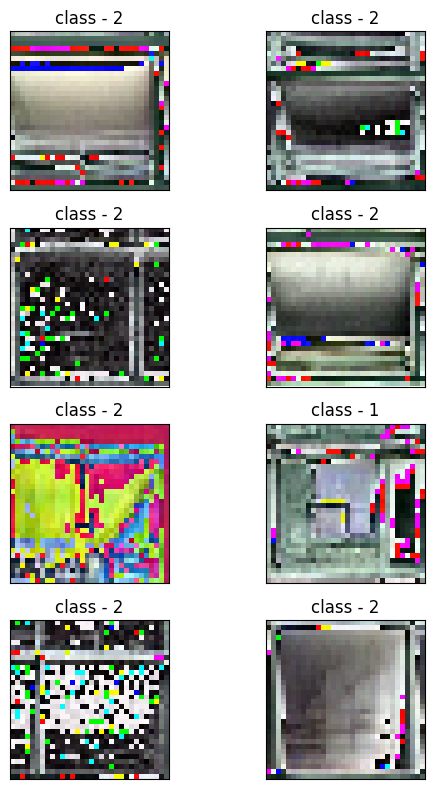

In [ ]:
fig = plt.figure(figsize=(8,8))
for IMG, label in (look_flow):
    for i in range(8):
        fig.add_subplot(4, 2, i+1)
        plt.imshow(IMG[i].to(torch.uint8).permute(1, 2, 0))
        plt.title(f'class - {label[i]}')
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
    break

## Training Loop

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
  since = time.time()
  with TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    for epoch in range(num_epochs):
      print(f'Epoch {epoch}/{num_epochs - 1}')
      print('-' * 10)

      for phase in ['train', 'val']:
        if phase == 'train':
          model.train()  # Set model to training mode
        else:
          model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0
        running_pre = 0
        running_rec = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
          inputs = inputs.to(device)
          labels = labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward
          # track history if only in train
          with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            pre = precision_score(preds.to('cpu'), labels.to('cpu'), average='micro')
            rec = recall_score(preds.to('cpu'), labels.to('cpu'), average='micro')
            loss = criterion(outputs, labels)


            # backward + optimize only if in training phase
            if phase == 'train':
              loss.backward()
              optimizer.step()

                    # statistics
          running_loss += loss.item() * inputs.size(0)
          running_pre += pre * inputs.size(0)
          running_rec += rec * inputs.size(0)
          count = inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)
        if phase == 'train':
          scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        epoch_pre = running_pre / dataset_sizes[phase]
        epoch_rec = running_rec / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Pre: {epoch_pre:.4f} Rec: {epoch_rec:.4f}')

                # deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
          best_acc = epoch_acc
          torch.save(model.state_dict(), 'drive/MyDrive/Colab Notebooks/samolet/data/train/model/resnet2209_3.pth')


      print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(torch.load('drive/MyDrive/Colab Notebooks/samolet/data/train/model/resnet2209_3.pth'))
  return model

## Load Pretrained Model

In [ ]:
model_rn = models.resnet18(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 266MB/s]


In [ ]:
#model_rn

In [ ]:
num_ftrs = model_rn.fc.in_features
model_rn.fc = nn.Linear(num_ftrs, 3)

model_rn = model_rn.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_rn = optim.SGD(model_rn.parameters(), lr=0.005, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_rn, step_size=7, gamma=0.1)

In [ ]:
#checkpoint = torch.load('drive/MyDrive/Colab Notebooks/samolet/data/train/model/resnet2209_2_chkp.pth')
#model_rn.load_state_dict(checkpoint['model_state_dict'])
#optimizer_rn.load_state_dict(checkpoint['optimizer_state_dict'])
#model_rn.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Train for cut cells classifiction

In [ ]:
model_rn = train_model(model_rn, criterion, optimizer_rn, exp_lr_scheduler,
                       num_epochs=30)

In [ ]:
torch.save({
            'model_state_dict': model_rn.state_dict(),
            'optimizer_state_dict': optimizer_rn.state_dict(),
            }, 'drive/MyDrive/Colab Notebooks/samolet/data/train/model/resnet2209_3_chkp.pth')

In [ ]:
torch.save(model_rn.state_dict(), 'drive/MyDrive/Colab Notebooks/samolet/data/train/model/resnet2209_3.pth')

## Test

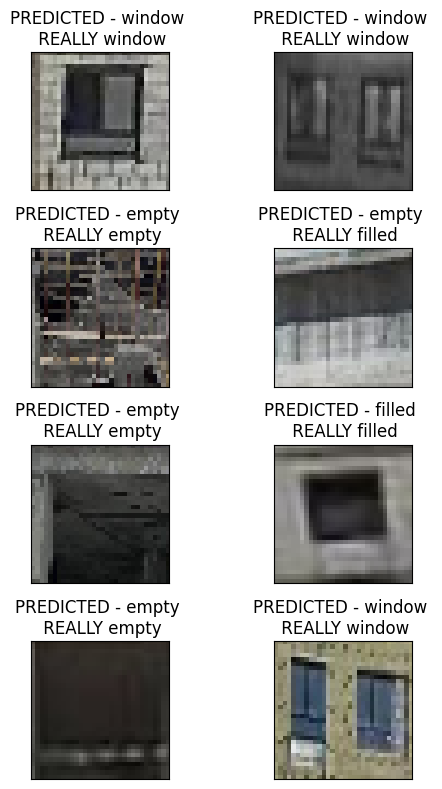

In [ ]:
description = pd.read_csv('drive/MyDrive/Colab Notebooks/samolet/data/train/cells_0/description_0.csv')
class_names = {0: 'window', 1: 'empty', 2: 'filled'}

model_rn.eval()
idx = np.random.randint(0, description.shape[0], 8)
fig = plt.figure(figsize=(8,8))

for i in range(len(idx)):
  path = cellDir + description.loc[idx[i], :]['file']
  image = transforms.Resize((32, 32))(read_image(path).to(torch.float32))
  target = description.loc[idx[i], :]['target']
  with torch.no_grad():
    input = image.unsqueeze(0).to(device)
    outputs = model_rn(input)
    _, preds = torch.max(outputs, 1)
    fig.add_subplot(4, 2, i+1)
    plt.title(f'PREDICTED - {class_names[preds.cpu().detach().numpy()[0]]} \n REALLY {class_names[target]}')
    plt.imshow(image.to(torch.uint8).permute(1, 2, 0))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

## Contours Searching Function

In [ ]:
def preprocessing(path: str):
  img_in = cv2.imread(path)
  img = img_in
  img_1 = img
  imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  imgray = cv2.convertScaleAbs(imgray, alpha=-1.5, beta=10)
  ret, thresh = cv2.threshold(imgray, 127, 255, 0)
  contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  #img_contours = np.uint8(np.zeros((img.shape[0],img.shape[1])))
  #cont = cv2.drawContours(img, contours, -1, (255,255,0), 1)
  rect = []
  box = []
  for c in contours:
    if img.shape[1] < 500:
      tr = .025
    else:
      tr = .05
    approx = cv2.approxPolyDP(c, .1*cv2.arcLength(c, True), True)

    if len(approx) == 4 and cv2.arcLength(c, True) >= tr * img_in.shape[1] \
    and cv2.arcLength(c, True) <= 100 * tr * img_in.shape[1]:
      x, y, w, h = cv2.boundingRect(c)
      rect.append([x, y, w, h])
      box.append([x, y, x+w, y+h])
      for r in rect:
        pic = cv2.rectangle(img_1, (r[0], r[1]), (r[0]+r[2], r[1]+r[3]), (0,255,0), 3)
    else:
      pic = img_1
  return pic, rect, box

## Cells cut Function

In [ ]:
def cut(path: str, rectangles: list):
  image = cv2.imread(path)
  cells = []
  for r in rectangles:
    cells.append(image[r[1]:r[1]+r[3], r[0]:r[0]+r[2]])
  return cells

## Contours Searching + Classifier

In [ ]:
model_1 = models.resnet18()
num_ftrs = model_1.fc.in_features
model_1.fc = nn.Linear(num_ftrs, 3)
model_1.load_state_dict(torch.load('drive/MyDrive/Colab Notebooks/samolet/data/train/model/resnet2209_1.pth', map_location=torch.device('cpu')))
model_1.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
image_names = []
for filename in os.listdir(dataDir_1):
  if 'jpg' in filename.lower():
    image_names.append(filename)
descr = pd.DataFrame(data={
    'file': image_names,
    'target': None})

In [ ]:
path = 'drive/MyDrive/Colab Notebooks/samolet/data/train/images/' + descr['file'][100]

In [ ]:
test_tr = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

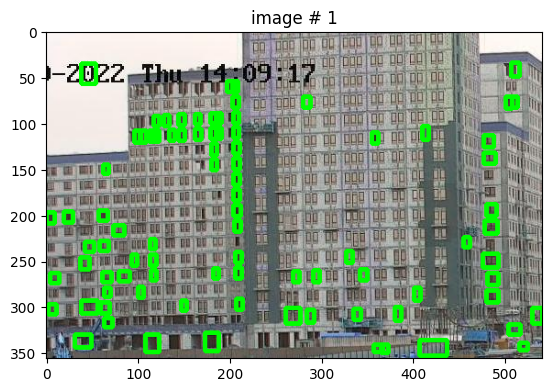

['2 1.0 530 301 541 318', '2 1.0 365 341 373 350', '2 1.0 357 341 367 349', '2 1.0 516 339 525 347', '2 1.0 407 336 437 353', '2 1.0 108 330 123 349', '2 1.0 31 330 49 344', '2 1.0 173 328 188 348', '2 1.0 504 319 517 330', '2 1.0 63 312 72 322', '2 1.0 284 303 292 317', '2 1.0 335 302 343 314', '2 1.0 261 301 277 318', '2 1.0 380 300 387 315', '2 1.0 2 297 11 308', '2 1.0 59 295 69 307', '2 1.0 147 293 153 304', '2 1.0 38 293 56 307', '2 1.0 207 291 214 303', '2 1.0 480 282 493 295', '2 1.0 401 279 408 293', '2 1.0 63 279 70 289', '2 1.0 100 278 106 290', '2 1.0 481 263 493 276', '2 1.0 4 263 14 274', '2 1.0 61 262 71 273', '2 1.0 269 261 276 273', '2 1.0 79 261 91 272', '2 1.0 291 260 298 273', '2 1.0 114 260 120 271', '2 1.0 342 259 350 271', '2 1.0 182 258 188 269', '2 1.0 206 257 213 269', '2 1.0 37 246 47 259', '2 1.0 113 243 120 255', '2 1.0 93 243 99 255', '2 1.0 476 242 493 257', '2 1.0 206 240 213 252', '2 1.0 327 239 334 252', '2 1.0 42 229 52 240', '2 1.0 58 228 68 239', '2

In [ ]:
plt.title(f'image # {1}')
image = preprocessing(path)[0]
plt.imshow(image)
plt.show()
j = 0
formatted = []
count = 0
for c in cut(path, preprocessing(path)[1]):
  xmin, ymin, xmax, ymax = preprocessing(path)[2][count]
  t_img = test_tr(c).unsqueeze(0)
  outputs = model_1(t_img)
  score, lbl = torch.max(outputs, 1)
  st = f"{int(lbl)+1} {round(float(score) / float(max(max(outputs))), 4)} {xmin} {ymin} {xmax} {ymax}"
  formatted.append(st)
  count += 1

print(formatted)
print('___________-')